# Image filtering Khaliq Aghakarimov

## Setting Khaliq Aghakarimov

### move to the working directory Khaliq Aghakarimov

For colab user (cf previous chapter):

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
%cd /gdrive/My\ Drive

/gdrive/My Drive


For non-colab user:

    %cd theGoodPlace

For every body, if it was not already  made:

In [0]:
%mkdir vigonLectures
%mkdir vigonLectures/signal

mkdir: cannot create directory ‘vigonLectures’: File exists
mkdir: cannot create directory ‘vigonLectures/signal’: File exists


In [0]:
%cd vigonLectures/signal

/gdrive/My Drive/vigonLectures/signal


We also create a directory where we will put the images that we will create

In [0]:
%mkdir out

mkdir: cannot create directory ‘out’: File exists


### Pull data Khaliq Aghakarimov

In [0]:
"we import (=clone) all the data or just update (=pull) them"

import os

if not os.path.exists("assets_signal"):
    print("the directory assets_signal is created")
    !git clone https://github.com/vincentvigon/assets_signal
else:
    print("the directory assets_signal is updated")
    %cd assets_signal
    !git pull https://github.com/vincentvigon/assets_signal
    %cd ..

### Import Khaliq Aghakarimov

In [0]:
%reset -f

In [0]:
import numpy as np
import scipy
from scipy import signal as sg
from scipy import ndimage
import  matplotlib.pyplot as plt

import imageio
import numpy
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("default")
import IPython

np.set_printoptions(linewidth=500,suppress=True,precision=5)

### One image Khaliq Aghakarimov

We import an image and keep only one channel. Data are converted as floats and standardized. So pixels range in $[0,1]$. 

In [0]:
img_origin = imageio.imread("assets_signal/babouin/babouin_moyen.jpg")[:,:,0].astype(np.float32)
img_origin/=255.
img_origin.shape,img_origin.dtype,np.max(img_origin)

((328, 273), dtype('float32'), 1.0)

## Convolution Khaliq Aghakarimov

### Convolution by ourself Khaliq Aghakarimov

The discrete convolution between an image (with one channel) and a mask (=a small matrix) is: 
$$
\Big(imgage \star mask\Big) [i,j]  = \sum_{di,dj} image[i+di,j+dj] \, mask[di, dj] 
$$
It is a sort of moving average along the image, ponderated by the mask. 


***To you:*** $(1\heartsuit)$ Do you see some difference with the 'mathematical' convolution?


Here is a natural implementation using 4 loops: 2 explicits (for-loop) and 2 implicit (`numpy` loop).

In [0]:
def convolution2D(image, mask):
   
    assert mask.shape[0]%2==1 and mask.shape[1]%2==1, "we want mask with a pixel at the center"

    h,w=image.shape
    
    II,JJ=mask.shape
    I = (II-1) // 2
    J = (JJ-1) // 2

    """we add padding (=marge) to avoid side problems.
    One can also use np.pad() """
    img_pad = np.zeros([h+2*I,w+2*J])
    img_pad[I:-I,J:-J]=image
    
    res=np.zeros_like(image)
    
    for i in range(0,h):
        for j in range(0,w):
            #print(img_pad[i:i+II , j:j+JJ].shape)
            res[i,j]=np.sum(img_pad[i:i+II , j:j+JJ] * mask)                        
    return res
            

In [0]:
image=img_origin.copy()
II=21
JJ=3
mask = np.ones((II,JJ))/II/JJ
print(mask)

[[0.01587 0.01587 0.01587]
 [0.01587 0.01587 0.01587]
 [0.01587 0.01587 0.01587]
 [0.01587 0.01587 0.01587]
 [0.01587 0.01587 0.01587]
 [0.01587 0.01587 0.01587]
 [0.01587 0.01587 0.01587]
 [0.01587 0.01587 0.01587]
 [0.01587 0.01587 0.01587]
 [0.01587 0.01587 0.01587]
 [0.01587 0.01587 0.01587]
 [0.01587 0.01587 0.01587]
 [0.01587 0.01587 0.01587]
 [0.01587 0.01587 0.01587]
 [0.01587 0.01587 0.01587]
 [0.01587 0.01587 0.01587]
 [0.01587 0.01587 0.01587]
 [0.01587 0.01587 0.01587]
 [0.01587 0.01587 0.01587]
 [0.01587 0.01587 0.01587]
 [0.01587 0.01587 0.01587]]


In [0]:
%%time 
imageConv = convolution2D(image,mask)

CPU times: user 499 ms, sys: 428 µs, total: 499 ms
Wall time: 501 ms


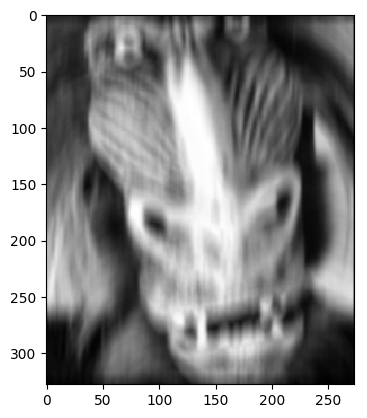

In [0]:
plt.imshow(imageConv,cmap='gray');

***To you:*** 

* $(1\heartsuit)$ Explain the visual aspect of the image above. 

* $(2\heartsuit)$ Find a mask of shape $5\times5$ that just decay the image.
*  $(2\heartsuit)$ Find a mask of shape $3\times3$ which allow to show the vertical variations of the image. If you have no idea, it will come during this chapter. 

### With a rolling window Khaliq Aghakarimov

A natural way to implement the convolution is to use a rolling window. 

In [0]:
""" this function produce a rolling window which is just a view on the data: 
= a special way to move in the data. No copy is made.
"""
def rolling_windows_img(a,kshape):
    outShape=(a.shape[0]-kshape[0]+1,)+(a.shape[1]-kshape[1]+1,)+kshape
    outStrides=a.strides+a.strides
    return np.lib.stride_tricks.as_strided(a,shape=outShape,strides=outStrides)

In [0]:
rolling=rolling_windows_img(image,mask.shape)
rolling.shape

(308, 271, 21, 3)

In [0]:
pre_imageConv=rolling * mask[np.newaxis,np.newaxis,:,:]
pre_imageConv.shape

(308, 271, 21, 3)

***To you:*** 

* $(2\heartsuit)$ Finish the job: make the convolution from the previous tensor. 
* $(2\heartsuit)$ Compare the performances with the first implementation. The creation of the rolling window must also be  counted. But, does it really take some time?

### Convolution by scipy Khaliq Aghakarimov

Now we use the `scipy` function. It is faster because all the 4 loops are implicit. 

In [0]:
%time 
imageConv2 = sg.convolve(image,mask,mode="same")

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 7.63 µs


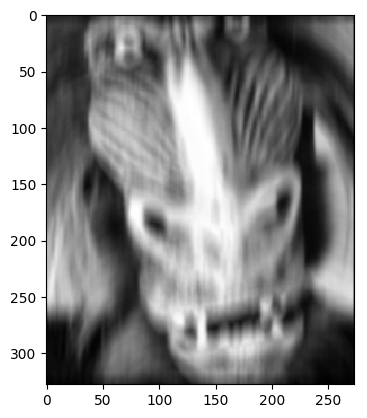

In [0]:
plt.imshow(imageConv2,cmap='gray');

Look at the docstring:   'mode'  can be :

        ``full``
           The output is the full discrete linear convolution
           of the inputs. (Default)
         => image size increases. 
        
         
        ``valid``
           The output consists only of those elements that do not
           rely on the zero-padding. In 'valid' mode, either `in1` or `in2`
           must be at least as large as the other in every dimension.
        => image size decreases
        
        ``same``
           The output is the same size as `in1`, centered
           with respect to the 'full' output.
           => image size stays the same
           
           
* The mode 'full' is not really interesting. 
* The mode 'same' is pratical because we keep the same dimensions. But you can observe some side effects (effet de bord). 
* If you use the mode 'valid', you loose a part of the image, but no side effects.  



***To you:*** 

* ($5\heartsuit\flat$) Modify the first convolution function to allow the 'valid' mode. The difficulty is to start the loops at the good index. 
* ($2\heartsuit$) Find a formula that relies the shapes of the image, the shape of the mask and the shape of  the result, when we use the 'valid' mode. 

## Smoothing Khaliq Aghakarimov

### Gaussian mask Khaliq Aghakarimov

A good mask to smooth an image is the gaussian mask: a discretisation of the gaussian density. This produice a moving-average, where the close pixels are more important than the far ones.

In [0]:
def gaussian_mask(shape=(3, 3), sigma=0.5):

    if len(shape)!=2: raise ValueError("len-2 shape required")
    if shape[0]%2!=1 or shape[1]%2!=1: raise ValueError("only odd sizes are OK")

    m,n = (shape[0]-1)/2,(shape[1]-1)/2
    y,x = np.ogrid[-m:m+1,-n:n+1]
    res = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )

    
    """normalization"""
    res/=res.sum()
    return res

In [0]:
print(gaussian_mask((11, 11)))

[[0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.     ]
 [0.      0.      0.      0.      0.00003 0.00021 0.00003 0.      0.      0.      0.     ]
 [0.      0.      0.      0.00003 0.01133 0.08373 0.01133 0.00003 0.      0.      0.     ]
 [0.      0.      0.      0.00021 0.08373 0.61869 0.08373 0.00021 0.      0.      0.     ]
 [0.      0.      0.      0.00003 0.01133 0.08373 0.01133 0.00003 0.      0.      0.     ]
 [0.      0.      0.      0.      0.00003 0.00021 0.00003 0.      0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.     ]

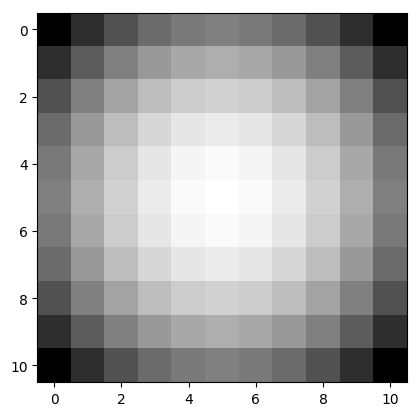

In [0]:
plt.imshow(np.log(gaussian_mask((11, 11))),cmap="gray");

Let's soften a gaussian noise with a gaussian mask:

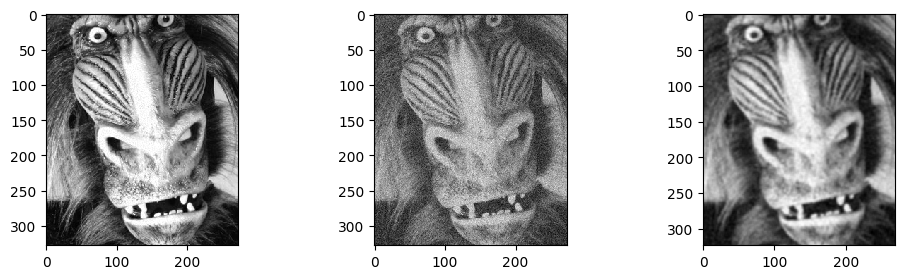

In [0]:
image=img_origin.copy()

"""random noise (with gaussian distribution)"""
image+=np.random.normal(scale=0.1,size=image.shape)
masque = gaussian_mask(shape=(5,5),sigma=2.)
imageConv=sg.convolve(image,masque, "valid")

fig,(ax0,ax1,ax2)=plt.subplots(1,3,figsize=(12,3))
ax0.imshow(img_origin, cmap='gray')
ax1.imshow(image,cmap='gray')
ax2.imshow(imageConv, cmap='gray');

***To you:*** $(1\heartsuit)$ Which sort of noise can be soften with a Gaussian mask?

### Impultional noise and median filter Khaliq Aghakarimov

An impultional noise is a strong perturbation, but which appears only at rare places.

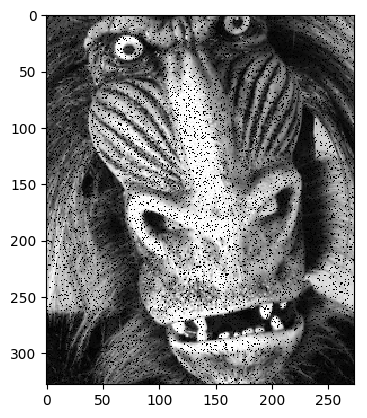

In [0]:
image=img_origin.copy()
proba=0.1
"""some pixels are modified (ex: parasite occuring during the transmission of the image)"""
image[np.random.uniform(size=image.shape)<proba]=0
plt.imshow(image,cmap="gray");

The median filter is perfect to suppress such a noise: You move a rolling window of a given size (ex: $3\times 3$). For each window,  you replace the pixel at the middle  by the median of the pixels of the window. Such a filter is present at two places in `scipy`: 

    scipy.signal.medfilt
    scipy.ndimage.filters.median_filter

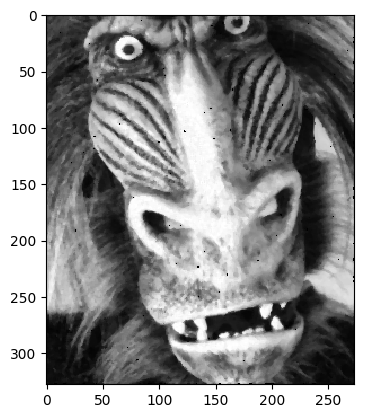

In [0]:
image_improved=scipy.signal.medfilt(image,kernel_size=3)
plt.imshow(image_improved,cmap="gray");

***To you:*** $(2\heartsuit)$  some pixel are still black. How it is possible.  Rule the filter to suppress them, but, what do you see then...

***To you:*** $(1\heartsuit)$ A filter is said linear when the application img$\to$Filter(img) is linear. Which filters we saw before is linear?

### A revolutionnary filter Khaliq Aghakarimov

Your chef has an idea (naturaly, a brilliant idea) for a new denoising filter which combine smoothing and median. He explains you this idea on the phone: 

<< Firstly, take a rolling window of size $5\times5$. Secondly, for each window, sort the pixels. Thirdly ... >>

Heck! The phone stops. No need to re-contact your chef. Create this revolutionnary filter by yourself $(8\heartsuit\flat)$.



## Edges filters Khaliq Aghakarimov

The purpose is to detect edeges (=contours) on images. We will



### principle of 1D signal Khaliq Aghakarimov

Let's consider a simple signal 1D

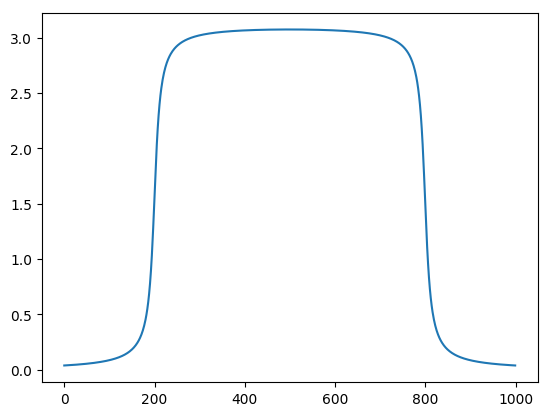

In [0]:
def buildSignal()->np.ndarray:
    a=50
    dec=30
    x=np.linspace(-a,a,1000)
    y1=np.arctan(x+dec)
    y2=np.arctan(-x+dec)
    return y1+y2

y=buildSignal()
plt.plot(y);

Whats we called contour are the fast variations of this signal. Let's us compute its discrete first and second derivation: 

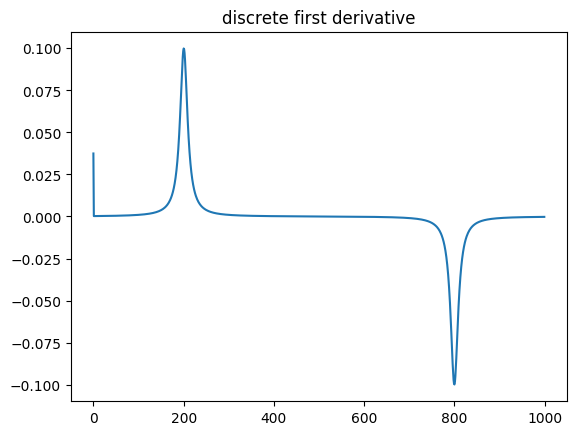

In [0]:
y_decay_right=np.zeros_like(y)
y_decay_right[1:]=y[:-1]

yDiff =  (y - y_decay_right)
plt.title("discrete first derivative")
plt.plot(yDiff);

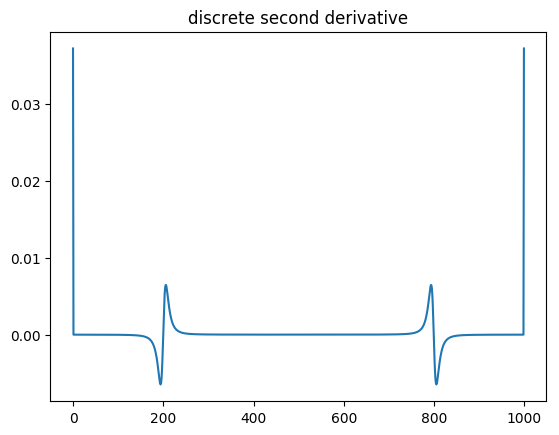

In [0]:
y_decay_left=np.zeros_like(y)
y_decay_left[:-1]=y[1:]

y_diff2=2*y-y_decay_left-y_decay_right
plt.title("discrete second derivative")
plt.plot(y_diff2);

So we have two ways for detecting the contours:

* Detect the extreme values of the first derivative.
* Detect the zero-crossing ot the second derivative. 

***To you:*** 

* $(2\heartsuit)$ Recompute these discrete derivations with convolutions, using `scipy`. 
*  $(1\heartsuit)$ Modify the two previous plot, so that the discrete derivative looks like the true derivative. 

###The norm of gradients Khaliq Aghakarimov

In [0]:
img_grid = imageio.imread("assets_signal/grille.gif")
img_grid.shape,img_grid.dtype,np.max(img_grid)

((256, 256), dtype('uint8'), 255)

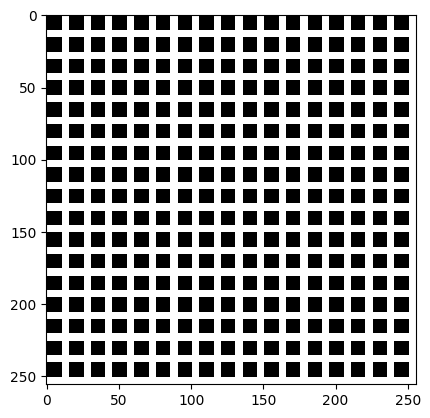

In [0]:
plt.imshow(img_grid, cmap='gray');

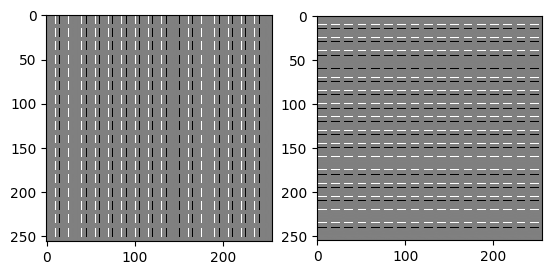

In [0]:
"""we compute the horizontal and vertical gradients with convolutions"""
Gx = sg.convolve(img_grid, [[1., -1]], "valid")
Gy = sg.convolve(img_grid, [[1.], [-1]], "valid")

plt.subplot(1,2,1)
plt.imshow(Gx, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(Gy, cmap='gray');


***To you:*** 

* $(2\heartsuit)$ Compute and plot the norm of the gradient. Let's denote it by $N$.  

*  $(2\heartsuit)$  Choose a good thresold (=seuil) $S$ and plot the places where $N>S$. You would see the contours appear. 

* $(2\heartsuit\flat)$ The purpose of this exercise is to emphasize the link between 1D and 2D signals. Plot some vertical and horizontal slices of the grid image, and of these gradients.  Ex: an hozirontal slices of a matrix $M[i,j]$ is $j\to M[i_o,j]$.





### Smoothing before  Khaliq Aghakarimov


***To you:*** Try  $(3\heartsuit)$  various gaussian smoothing before the previous contour detection: you would constast this trade-off:

* Strong smoothing: the detection is robust against the noise, but the contours are thick.

* Weak smoothing: sensibility to the noise, but fine localisation of the contour. 


###  Angles of  gradients Khaliq Aghakarimov

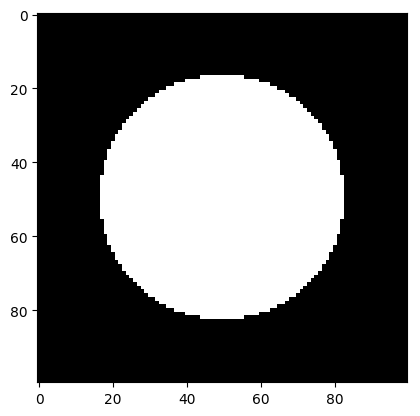

In [0]:
x=np.linspace(-1.5,1.5,100)
xx,yy=np.meshgrid(x,x)
disk=(xx**2+yy**2)<1

plt.imshow(disk,cmap="gray");

***To you:*** 

* $(2\heartsuit)$ Find the edge of the disk above. 
* $(2\heartsuit)$  All allong this edge, compute the angle of the gradient. Help: use `np.arctan2(y,x)`
* $(4\heartsuit\flat)$  Make a graphical representation of this angles. you can use arrows or you can convert the angles into a hue.

## Cany filter Khaliq Aghakarimov


Cany filters, and its refinement are the best "unsupervised" methodes to detect edges. Recently, the deep-learning allows more accurate detection, but for training the models, we need a huge number of  images where edges are anotated by hand. 

There is an already-made function to perform the cany filter: 

        from skimage import feature
        edges = feature.canny(image)

But we will re-implement it in detail: the different ideas of this algorithm could help you in many other situations.  

### Other gradient operator Khaliq Aghakarimov

They are  many possible discretisations for the gradient-operator:

In [0]:
"""sobel, so-chouette"""
def sobel_operators():
    Sx=[[-1,0,1],
        [-2,0,2],
        [-1,0,1]]

    Sy=[[ 1, 2, 1],
        [ 0, 0, 0],
        [-1,-2, -1]]

    sobel=np.stack([Sx,Sy])
    
    return sobel

""" Prewit: idem as sobel, changing the 2 into 1 (less good)"""


"""Robert: diagonal gradients"""
def robert_operators():
    Rx=[[1,0],
        [0,-1]]

    Ry=[[ 0,1],
        [-1,0]]

    R=np.stack([Rx,Ry])
    
    return R

In [0]:
print(sobel_operators())

[[[-1  0  1]
  [-2  0  2]
  [-1  0  1]]

 [[ 1  2  1]
  [ 0  0  0]
  [-1 -2 -1]]]


There are also the compass operators which compute the gradient in the 8 natural directions (North, North-West, West, ...):

In [0]:
def getCompassOperators(kind:str):
    res=np.empty([8,3,3])
    
    if kind=="kirsch":
        conv_mask = np.array([5,  5, 5,-3,-3,-3,-3,-3])
    elif kind=="robinson2":
        conv_mask = np.array([1,2,1,0,-1,-2,-1,0])
    elif kind=="robinson1":
        conv_mask = np.array([1,1,1,0,-1,-1,-1,0])
    
    
    for i in range(8):
        oneDir=np.zeros(9)
        oneDir[[0,1,2,5,8,7,6,3]]=conv_mask
        "to turn the coef"
        conv_mask=np.concatenate([conv_mask[1:],conv_mask[0:1]])
        res[i,:,:]=oneDir.reshape([3,3])
        
    return res
    

In [0]:
getCompassOperators("robinson2") 

array([[[ 1.,  2.,  1.],
        [ 0.,  0.,  0.],
        [-1., -2., -1.]],

       [[ 2.,  1.,  0.],
        [ 1.,  0., -1.],
        [ 0., -1., -2.]],

       [[ 1.,  0., -1.],
        [ 2.,  0., -2.],
        [ 1.,  0., -1.]],

       [[ 0., -1., -2.],
        [ 1.,  0., -1.],
        [ 2.,  1.,  0.]],

       [[-1., -2., -1.],
        [ 0.,  0.,  0.],
        [ 1.,  2.,  1.]],

       [[-2., -1.,  0.],
        [-1.,  0.,  1.],
        [ 0.,  1.,  2.]],

       [[-1.,  0.,  1.],
        [-2.,  0.,  2.],
        [-1.,  0.,  1.]],

       [[ 0.,  1.,  2.],
        [-1.,  0.,  1.],
        [-2., -1.,  0.]]])

***To you:*** $(1\heartsuit)$ Associate to each operator of the list above its direction (North,North-West,...). Rem: you probably have to make an arbitrary choice.


***To you:*** $(2\heartsuit)$: when you change from an operator to another (ex: from ), the magnitude of the gradients can change a lot. This is a bit enoying, because you have to adapt the threshold. Explain how modify these operator to limitate these amplitude variation.  

### Cany filter Khaliq Aghakarimov


The principle is to find the places where the gradients reach a local maximum when we travel in the image folloging the 4 possible directions:

* North $\to$ South
* West $\to$ East
* Sud-West $\to$ Nord-East
* Sud-East $\to$ Nord-West

In [0]:
def create_simple_img(choice):
    x=np.linspace(0,1,14)
    xx,yy=np.meshgrid(x,x)
    
    if choice==0:
        img_simple=((xx<0.5)&(yy<0.5))*10
    if choice==1:
        img_simple=(xx>yy)*10
        
    return img_simple
        

In [0]:
img_simple=create_simple_img(0)
print(img_simple)

[[10 10 10 10 10 10 10  0  0  0  0  0  0  0]
 [10 10 10 10 10 10 10  0  0  0  0  0  0  0]
 [10 10 10 10 10 10 10  0  0  0  0  0  0  0]
 [10 10 10 10 10 10 10  0  0  0  0  0  0  0]
 [10 10 10 10 10 10 10  0  0  0  0  0  0  0]
 [10 10 10 10 10 10 10  0  0  0  0  0  0  0]
 [10 10 10 10 10 10 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


In [0]:
img_simple=create_simple_img(1)
print(img_simple)

[[ 0 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [ 0  0 10 10 10 10 10 10 10 10 10 10 10 10]
 [ 0  0  0 10 10 10 10 10 10 10 10 10 10 10]
 [ 0  0  0  0 10 10 10 10 10 10 10 10 10 10]
 [ 0  0  0  0  0 10 10 10 10 10 10 10 10 10]
 [ 0  0  0  0  0  0 10 10 10 10 10 10 10 10]
 [ 0  0  0  0  0  0  0 10 10 10 10 10 10 10]
 [ 0  0  0  0  0  0  0  0 10 10 10 10 10 10]
 [ 0  0  0  0  0  0  0  0  0 10 10 10 10 10]
 [ 0  0  0  0  0  0  0  0  0  0 10 10 10 10]
 [ 0  0  0  0  0  0  0  0  0  0  0 10 10 10]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 10 10]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


To well understant the following, do not hesitate to run the programs this the 2 variants of `img_simple`


We compute the gradients accoring to the 4 possible directions:

In [0]:
operators=getCompassOperators("robinson2")
all_grad = np.abs(np.array([sg.convolve(img_simple, operators[i,:,:], "valid") for i in range(4)]))
all_grad.shape

(4, 12, 12)

For each pixel, we look at the direction which have the greatest gradient. 

In [0]:
""" when the max is reached in several indices, it is the smallest which is chosen. ex:0=np.argmax([10,10,5]) """
direction = np.argmax(all_grad, axis=0)
print(direction)

[[0 0 0 0 0 2 2 0 0 0 0 0]
 [0 0 0 0 0 2 2 0 0 0 0 0]
 [0 0 0 0 0 2 2 0 0 0 0 0]
 [0 0 0 0 0 2 2 0 0 0 0 0]
 [0 0 0 0 0 2 2 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


We also keep the value of the maximum gradients.

In [0]:
grad=np.max(all_grad,axis=0)
print(grad)

[[ 0.  0.  0.  0.  0. 40. 40.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 40. 40.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 40. 40.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 40. 40.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 40. 40.  0.  0.  0.  0.  0.]
 [40. 40. 40. 40. 40. 40. 30.  0.  0.  0.  0.  0.]
 [40. 40. 40. 40. 40. 30. 20.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


We create a zero-matrix where the edges will be stack.

In [0]:
Z=np.zeros(direction.shape,dtype=np.int8)

In the 4 next cells, we look for the local maximums of the gradient along the 4 possibles directions.


For performance, we use some optimization of numpy:

* `np.add(a,b)` is the same as `a+b`, but its allow more arguments:
* `where=mask` allow to make the sum where the mask indicates `True`
* `out=` allow to precise the matrix where the result of the sum is put. Its allows to work 'in place' = without create a new array. 

Actually the arguments `out` and `where` are present in almost all numpy functions.  Alternatively, one can also works with the numpy-masked-array (but I am not familiar with).   

In [0]:
part=grad[1:-1, :]
np.add(Z[1:-1, :], 
       (part>=grad[2:, :]) & (part>grad[:-2, :]), 
       where=direction[1:-1, :] == 0, 
       out=Z[1:-1, :]
      )
print(Z)

[[0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [2 2 2 2 2 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


In [0]:
part=grad[1:-1, 1:-1]
np.add(Z[1:-1, 1:-1], 
       (part>= grad[:-2, 2:]) & (part>grad[2:, :-2]), 
       where=direction[1:-1, 1:-1] == 3, 
       out=Z[1:-1, 1:-1])
print(Z)

[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


In [0]:
part=grad[:, 1:-1]
np.add(Z[:,1:-1],      
       (part >= grad[:, 2:]) & (part>grad[:, :-2]), 
       where=direction[:, 1:-1] == 2, 
       out=Z[:, 1:-1])
print(Z)

[[0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


In [0]:
part=grad[1:-1, 1:-1]
np.add(Z[1:-1, 1:-1],
       (part >= grad[2:, 2:]) & (part>grad[:-2, :-2]),
       where=direction[1:-1, 1:-1] == 1,
       out=Z[1:-1, 1:-1]
      )
print(Z)

[[0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


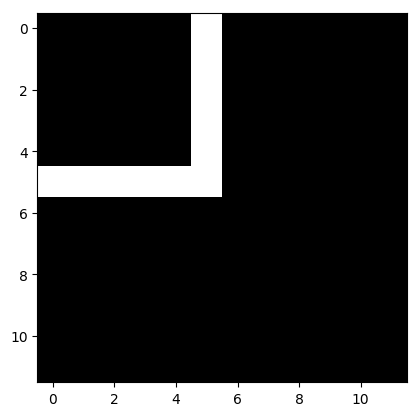

In [0]:
plt.imshow(Z,cmap="gray");

***To you:*** 

* $(2\heartsuit)$In the expression: `(part>=grad[2:, :]) & (part>grad[:-2, :])`: why do we use a large and a strict inequality?

*  $(2\heartsuit)$  Why did we use only the 4 first Robinson operators? 


*  $(2\heartsuit)$  Make a simple image, where some local maximums are detected for the 4 directions (it was not the case for our 2 first simple images).

### Hysteresis Thresholding Khaliq Aghakarimov


The edge detection is not finished: if we keep all the pixels such that `Z>0`, we would also detect very light edges: some edges that we would do not detect with our eyes. Indeed: `Z` is computed from local maximums, and not from the absolute value of the gradients. 


The Cany filter use the "hysteresis thresholding" which require two thresholds: `low_thr` and `high_thr` with  `0<low_thr<high_thr`.


*  pixels marked by the `Z` matrix,   such that  `grad>=high_thr` are marked as strong edges, and are  keept. 
* pixels such that `grad<=low_thr` are rejected
* for pixels marked by the `Z` matrix,   such that  `low_thr<grad<high_thr`, we look at their neighbours: if one of the neighbour is a strong edge, then the are keept, if not, they are rejected. 


***To you:***   Perhaps could you use an IDE (ex: pycharm) for the following exercise.

* $(4\heartsuit)$ Wrap all the previous code in a function. Test it.
* $(8\heartsuit)$ Add the final selection with thresholds. Test different  thresholds. The choice of such thresholds is delicate and depend on the image. In general, the low one is about half the high one. 
* $(4\heartsuit)$ Add also a preliminary gaussian smoothing, and test various `sigma`. 
* $(2\heartsuit)$ Explain the link between the args of your function and the args of the `scipy` that you get with: 

        from skimage import feature
        feature.canny?





### Color images Khaliq Aghakarimov

Here is 3 ways to use cany filter on RGB  images:

* Change the color image into a gray one. But you can miss some edges.
* Make the filtering for each channel, and sum the detected edges. This work well. 
* The optimal way is to consider mutli-dimensionnal gradients. A famous one is:
$$
\begin{pmatrix}
R^2_i+G^2_i+B^2_i & R_i R_j+G_iG_j+B_iB_j\\
R_iR_j+G_iG_j+B_iB_j & R^2_j+G^2_j+B^2_j
\end{pmatrix}
$$
where 

* $R_i [i,j]= R[i+1,j]-R[i,j]$ (the discrete gradient of the red-channel in the $i$-direction)
* $R_j [i,j]= R[i,j+1]-R[i,j]$
* ...

At each point `i,j` we take 

* `grad[i,j]` as the greatest eigen value of the previous matrix
* `direction[i,j]` as  the direction of the eigen vector associated the the greatest eigen value, that we round so its belongs to the 4 possible main directions. 

The following of the algorithm is the same: we keep only the local max of `grad[i,j]` in the direction `direction[i,j]` ... 


***To you:*** $(10\heartsuit\flat)$ Try this if you have time enough. To extract the greatest eigen value, use the `svd` (see below).



In [0]:
""" for symetric matrices, the svd decomposition gives  eigen vectors and values, sorted in the decreasing ordre """
mat=np.array([[2,-3],[-3,5]])
V,S,_=np.linalg.svd(mat)
v0=V[:,0]
print(mat@v0)
print(S[0]*v0)

[-3.60341  5.83045]
[-3.60341  5.83045]


## Second order filter $\flat$ Khaliq Aghakarimov

The Laplacian is a generalisation of the second order derivative. Ex: for a function $f$ with two variables, the laplacian $\Delta f$ is:
$$
\Delta f  = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} 
$$
Here are some possible discretizations of the Laplacian:

In [0]:
"""Discrete Laplacian 4"""
laplace1 = [[0, 1, 0],
            [1, -4, 1],
            0, 1, 0]

"""Discrete Laplacian 8"""
laplace2 = [[1, 1, 1],
            [1, -8, 1],
            [1, 1, 1]]

"""Robinson Laplacian (to take with you in a desert island)"""
laplace3 = [[1, -2, 1],
            [-2, 4, -2],
            [1, -2, 1]]

Let's denote by $\ell$ the laplacian of the image, which we can optain by the convolution between the image and one of the previous operator. Then let's write:
$$
L_{i,j} = (\ell_{i,j},\ell_{i+1,j},\ell_{i-1,j},\ell_{i,j+1},\ell_{i,j-1},\ell_{i+1,j+1},\ell_{i+1,j-1},\ell_{i-1,j+1},\ell_{i-1,j-1},)
$$
i.e the nine values of the laplacian around $i,j$.

The pixel $i,j$ belongs to an edge when:
$$
\max(L_{i,j})>0 \text{ and } \min(L_{i,j})<0  \text{ and } \max(L_{i,j})-\min(L_{i,j}) > \text{threshold}.
$$


***To you:*** $(10\heartsuit\flat)$ Try this if you have time enough. 